In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

In [133]:
stroke_df=pd.read_excel("stroke_history.xlsx")
stroke_df.head()

,Sex,Age,Prev_stroke_TIA_thromboembolia,chads_stroke,AF,CHF,vascular_disease,Diabetes,Hypertension,Alcohol,Smoking,Anticoag_prev,TAG_prev,DM_ther,LAA_thrombus
0,female,80,no,0,recent,0,0,1,1,no,no,no,no,insulin,yes
1,male,67,TIA,2,no,0,0,0,0,yes,no,no,no,no,no
2,male,55,kmn,0,no,0,0,0,0,no,no,no,no,no,no
3,female,79,TIA,2,known,1,1,0,1,no,no,Eliquis,no,no,no
4,female,88,no,0,no,1,1,1,1,yes,previous,no,no,no,?


In [ ]:
stroke_df["LA_vol_mL"].plot(kind='hist')

In [134]:
dummified = pd.get_dummies(stroke_df)
dummified.columns
y = dummified[["LAA_thrombus_yes", "LAA_thrombus_no", "LAA_thrombus_?"]]
x = dummified.drop(["LAA_thrombus_yes", "LAA_thrombus_no", "LAA_thrombus_?"], axis=1)

In [44]:
dummified.columns

Index(['Age', 'chads_age', 'chads_stroke', 'pangásos_SZE', 'vascular_disease',
       'Diabetes', 'Hypertension', 'chads_vasc', 'LA_vol_mL', 'EF',
       'Ao_insuff', 'Mitr_insuff', 'Tricusp_insuff', 'Sex_female', 'Sex_male',
       'Prev_stroke/TIA/thromboembolia_TIA',
       'Prev_stroke/TIA/thromboembolia_no',
       'Prev_stroke/TIA/thromboembolia_stroke', 'AF_known', 'AF_no',
       'AF_recent', 'Alcohol_no', 'Alcohol_yes', 'Smoking_no',
       'Smoking_previous', 'Smoking_yes', 'LAA_thrombus_?', 'LAA_thrombus_no',
       'LAA_thrombus_yes', 'fill_defect_no', 'fill_defect_oval',
       'fill_defect_small oval', 'fill_defect_triangular',
       'fill_defect_triangular+oval', 'wall_hypokinesis_diffúz',
       'wall_hypokinesis_inf. septum és inf. fal basalis fele',
       'wall_hypokinesis_no', 'wall_hypokinesis_yes'],
      dtype='object')

In [135]:
from sklearn.cross_decomposition import PLSRegression
plsr = PLSRegression(n_components=2, scale=False) # (1)
plsr.fit(x, y)

PLSRegression(scale=False)

ValueError: too many values to unpack (expected 2)

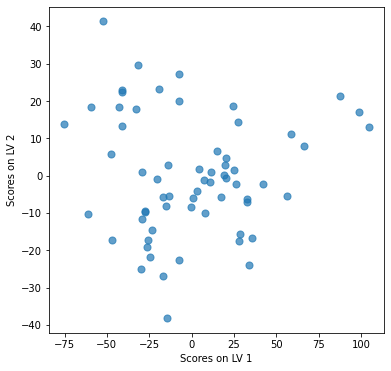

In [70]:
scores = pd.DataFrame(plsr.x_scores_)
scores.index=dummified.T.columns

ax = scores.plot(x=0, y=1, kind='scatter', s=50, alpha=0.7,
                    figsize=(6,6))
ax.set_xlabel('Scores on LV 1')
ax.set_ylabel('Scores on LV 2')
for n, (x, y) in enumerate(scores.values):
    label = scores.index.values[n][0]
    ax.text(x,y,label)

In [42]:
std_scores_dim1 = 2 * ( (scores[0] - min(scores[0])) / (max(scores[0]) - min(scores[0])) ) -1
std_scores_dim2 = 2 * ( (scores[1] - min(scores[1])) / (max(scores[1]) - min(scores[1])) ) -1

In [43]:
loadings_df = pd.DataFrame(plsr.x_loadings_)

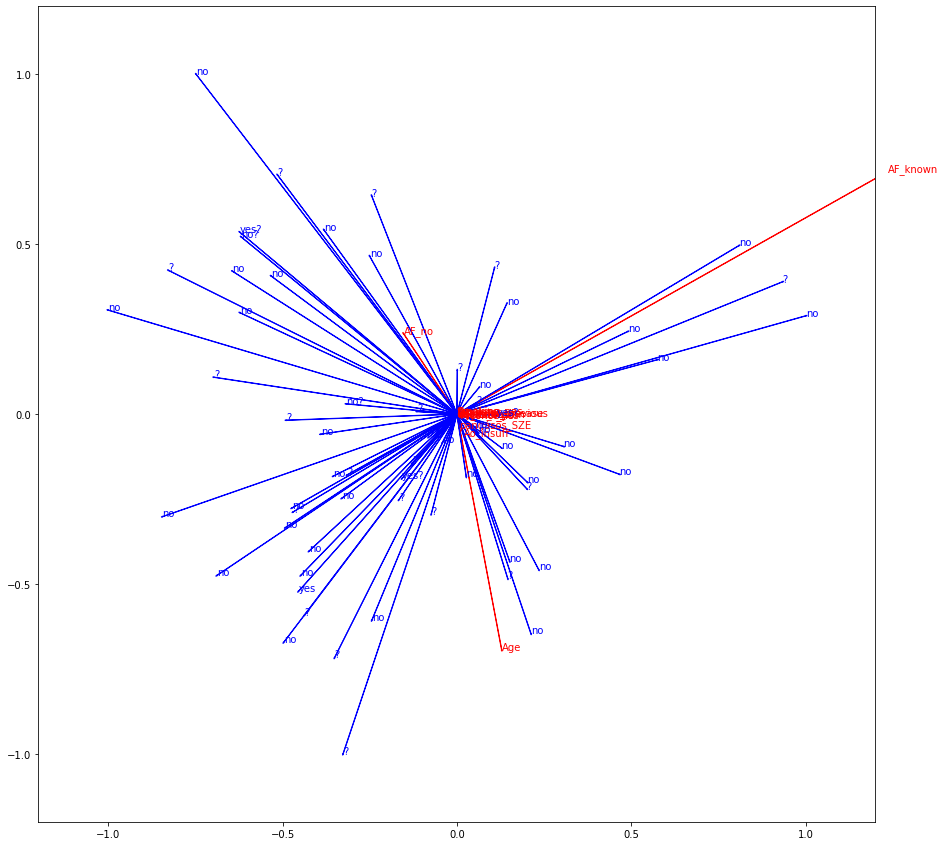

In [136]:
plt.figure(figsize=(15, 15))
plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))

desired_columns=['Age', 'pangásos_SZE', 'vascular_disease',
       'Diabetes', 'Hypertension', 'chads_vasc', 'EF',
       'Ao_insuff', 'AF_known', 'AF_no', 'AF_recent', 'Alcohol_no', 'Alcohol_yes', 'Smoking_no',
       'Smoking_previous', 'Smoking_yes']

for i, var_i in enumerate(desired_columns):
  x = loadings_df.loc[i, 0]
  y = loadings_df.loc[i, 1]

  plt.arrow(0,0,x,y, color= 'red')
  plt.text(x,y,var_i, color= 'red')

for i in range(len(std_scores_dim1)):
  x  = std_scores_dim1[i]
  y = std_scores_dim2[i]

  plt.arrow(0,0,x,y, color= 'blue')
  plt.text(x,y,stroke_df.loc[i, 'LAA_thrombus'], color= 'blue')

plt.show()

In [76]:
plsr.get_params()

{'copy': True,
 'max_iter': 500,
 'n_components': 5,
 'scale': False,
 'tol': 1e-06}

In [103]:
def vip(model):
  t = model.x_scores_
  w = model.x_weights_
  q = model.y_loadings_
  p, h = w.shape
  vips = np.zeros((p,))
  s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
  total_s = np.sum(s)
  for i in range(p):
      weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
      vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
  return vips

(array([19., 11.,  5.,  4.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([0.13331515, 0.52832413, 0.9233331 , 1.31834208, 1.71335106,
        2.10836004, 2.50336902, 2.898378  , 3.29338698, 3.68839596,
        4.08340494]),
 <BarContainer object of 10 artists>)

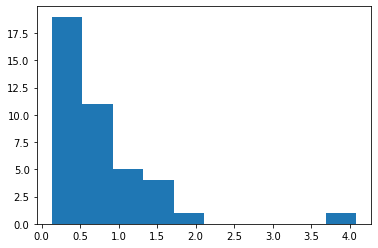

In [137]:
l=vip(plsr)
plt.hist(l)

In [127]:
plsr.x_weights_.shape

(35, 5)